### Name: Jin Yu
### CID: 01902266

In [1]:
!pip install pycm livelossplot
!pip install prettytable
%pylab inline

     |████████████████████████████████| 71kB 4.8MB/s 
     |████████████████████████████████| 573kB 17.8MB/s 
Populating the interactive namespace from numpy and matplotlib


#### Provided imports (add more you need them)

In [2]:
import random
import progressbar
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from livelossplot import PlotLosses
from sklearn.model_selection import StratifiedShuffleSplit

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1-Prepare your LeNet-5 network [10 points]
Use the code provided in the Jupyter Notebook template and modify it as you see fit to be able to perform a forward pass using the single dummy tensor input `x` provided. The lines of code that will do the forward pass and print the network are provided in the template.

In [3]:
#     make modifications in the code below

class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # the only change I made lies in this line, as the CIFAR-10 dataset has 3 channels,
    # we should make the first layer to have each filter with 3 channels;
    # also the dataset is size 32 * 32, to have output size of 28 * 28,
    # so (32 + 2 * p - 5) / 1 + 1 = 28 gives padding = 0.
    self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0) 

    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)   
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)   
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)    
    self.f6 = nn.Linear(120, 84)   
    self.output = nn.Linear(84, 10)  
    self.act = nn.ReLU()           
    
  def forward(self, x):
    x = self.act(self.c1(x)) 
    x = self.act(self.s2(x))   
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))    
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))     
    x = self.act(self.c5(x))    
    x = self.act(self.f6(x))    
    return self.output(x)          
  
# dummy input of the same size as the CIFAR-10 images
x = torch.ones((1, 3, 32, 32))
model = LeNet5()
y = model(x)

# print the model
print(model)

LeNet5(
  (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)


We could compare our LeNet5 model with this picture:
![](https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig3/AS:552880910618630@1508828489678/Architecture-of-LeNet-5.png)

They seem to fit quite well.

## 2-Load CIFAR-10 [10 points]
Use `torchvision.datasets.CIFAR10` to load the CIFAR-10 dataset (training and test sets).

In [4]:
# import package
from torchvision.datasets import CIFAR10
# load dataset for training
cifar_train = CIFAR10("./", download=True, train=True)
# load dataset for testing
cifar_test = CIFAR10("./", download=True, train=False)


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Let's observe some properties of the CIFAR-10 dataset,<br>
First check its shape:

In [5]:
# shape of training set
print("shape of training set:", cifar_train.data.shape)
# shape of test set
print("shape of testing set:", cifar_test.data.shape,"\n")
# print class label names
print("labels for training set:", cifar_train.class_to_idx)
print("labels for test set:", cifar_test.class_to_idx)

shape of training set: (50000, 32, 32, 3)
shape of testing set: (10000, 32, 32, 3) 

labels for training set: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
labels for test set: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


We can observe that both the training dataset and test dataset has each piece of its data (a photo) with size of 32 $\times$ 32, 3 channels. The training set has 50000 pieces of data while the test dataset has 10000 pieces of data.<br>
The dataset has 10 classes with labels (in number) from 0 to 9.

## 3-Plot data [5 points]
Plot 25 images of the training set together with their corresponding label names.

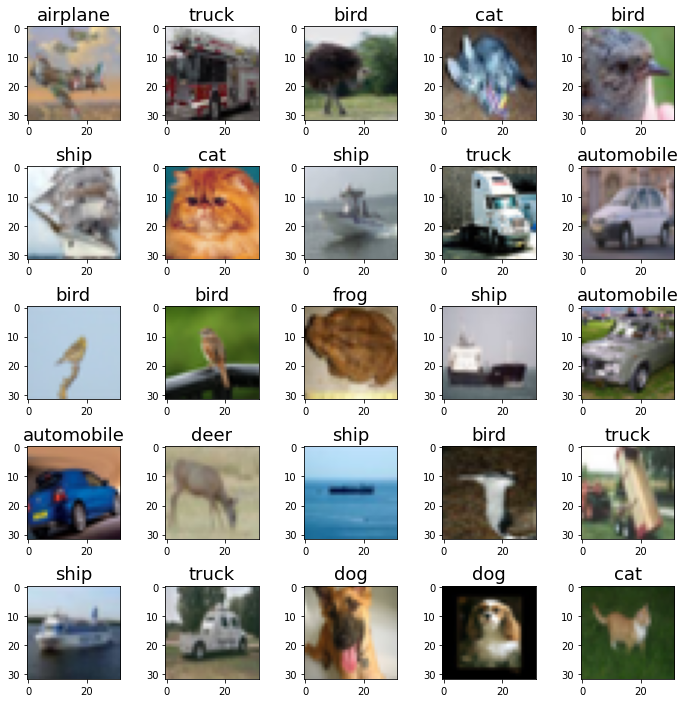

In [6]:
# set a figure with 25 subplots as required.
fig, axarr = plt.subplots(5, 5, figsize=(12, 12))
# adjust the vertical gap for subplots, sparing some place for label names.
pylab.subplots_adjust(hspace=0.5)
# we randomly pick 25 integers from (0, 50000).
picnums = np.random.randint(0,cifar_train.data.shape[0], 25)
# flip the keys and values of the cifar_train.class_to_idx dictionary for ease later.
labels = dict(zip(cifar_train.class_to_idx.values(), cifar_train.class_to_idx.keys()))

# loop over the 25 random integers we have, plot the corresponding picture in the training dataset, as well as their label names.
for ax, picnum in zip(axarr.flatten(), picnums):
  im = ax.imshow(cifar_train.data[picnum])
  ax.set_title(r'{0:}'.format(labels[cifar_train.targets[picnum]]), fontsize=18)

# show pictures
plt.show()

## 4-Create a training, validation split [5 points]
Split the data using `sklearn.model\_selection.StratifiedShuffleSplit`:

- 90\% of the data in the training set
- 10\% of the data in the validation set

Prepare the downloaded datasets to be used with your modified network in **1-Prepare your LeNet-5 network**

### Standardise the CIFAR-10 dataset

We first workout the range for the original CIFAR-10 data (training set), as well as its mean and standard derivation, then we apply a normalisation method to it.

In [7]:
# find max and mins
dmin = cifar_train.data.min()
dmax = cifar_train.data.max()
print("max:", dmax)
print("min:", dmin)
# find mean and standard derivations
mean_all = np.mean((cifar_train.data - dmin) /(dmax - dmin))
print('mean: ', mean_all)
std_all = np.std((cifar_train.data - dmin) /(dmax - dmin))
print('standard deviation: ', std_all)

max: 255
min: 0
mean:  0.4733630004850874
standard deviation:  0.25156892506322026


In [8]:
# define an standardisation function
def apply_standardization(X):
  X /= dmax
  X -= mean_all
  X /= std_all
  return X

In [9]:
# change to tensor
cifar_train.data = torch.from_numpy(cifar_train.data).permute(0,3,1,2)
cifar_test.data = torch.from_numpy(cifar_test.data).permute(0,3,1,2)
cifar_train.targets = torch.from_numpy(np.array(cifar_train.targets))
cifar_test.targets = torch.from_numpy(np.array(cifar_test.targets))

### Split the CIFAR-10 dataset (with 90% train and 10 % validation)

The ```sklearn.model_selection.StratifiedShuffleSplit``` function could return stratified randomized folds, which also preserves the percentage of samples for each class.

In [10]:
# split the data, set test_size=0.1 for 90:10 ratio for training/test dataset.
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(cifar_train.data, cifar_train.targets) 
# get the indices
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

# we print out the lengths of training/test datasets , as well as numbers for each class in each fold.
print(r"length of all data in training set and validation set: ({0:}, {1:})".format(len(indices[0]), len(indices[1])))
for j in range(10):
    print(r"number of data with label {0:} in training set and validation set: ({1:}, {2:})".format(j, \
    (cifar_train.targets[indices[0]]==0).sum(), (cifar_train.targets[indices[1]]==0).sum()))
print('\n')

length of all data in training set and validation set: (45000, 5000)
number of data with label 0 in training set and validation set: (4500, 500)
number of data with label 1 in training set and validation set: (4500, 500)
number of data with label 2 in training set and validation set: (4500, 500)
number of data with label 3 in training set and validation set: (4500, 500)
number of data with label 4 in training set and validation set: (4500, 500)
number of data with label 5 in training set and validation set: (4500, 500)
number of data with label 6 in training set and validation set: (4500, 500)
number of data with label 7 in training set and validation set: (4500, 500)
number of data with label 8 in training set and validation set: (4500, 500)
number of data with label 9 in training set and validation set: (4500, 500)




By `StratifiedShuffleSplit`, we could observe that, we not only split our data with a ratio of 90%:10% in training dataset and validation dataset, but also keep this ratio for each class lebel, in this case, 4500:500 = 9:1.

## 5-Grid search [20 points]
From  the  list  below,  select  two  hyperparameters  and  perform  a  2D  grid-search  to  find  the  optimal values for these two hyperparameters.  The range of values to test are provided.  Justify your choice of the two hyperparameters you want to tune (write a paragraph in a markdown cell explaining why you chose these two particular parameters). 

The list of hyperparameters to choose from is:

a)  Random Number Seed:  **42**  [31, 42, 53] \
b)  Learning Rate:  **1e-2**  [1e-1, 1e-2, 1e-3] \
c)  Momentum:  **0.5**  [0.2, 0.5, 0.8] \
d)  Batch Size:  **64**  [64, 128, 640] \
e)  Number of epochs:  **30**  [10, 30, 50]

The **values in bold** next to each hyperparameter are the values you need to use if you are not tuning this particular hyperparameter.  The values between square brackets are the values to use if you choose to tune this particular hyperparameter. Fixed hyperparameters:

- Optimiser:SGD+momentum
- Test batch size:1000

Write the results in two tables (one for the loss and one for the accuracy) where the columns and rows are the first and second hyperparameter have selected. You can use markdown tables or create the table in python.

You don’t need to plot all the livelossplotplots for each combination you try, as the results will be summarised in the table, but at least plot two of the grid-search runs. 

Select the best values for the two hyperparameters you have chosen to optimise and **justify your choice**.

 ### Set the hyperparameters
**Fixed:**
- Test Batch Size (no effect on training apart from time): 1000
- Shuffle the training set every epoch: Yes
- Optimiser: SGD + momentum
- Seed: 42
- Batchsize: 64
- Number of Epochs: 30

**My choice of tuning paramters:**
- learning rates: [1e-1, 1e-2, 1e-3]
- momentums: [0.2, 0.5, 0.8]<br>

The reason I choose to tune the learning rate is that different learning rate would lead huge difference in each step of gradient descent: <br>
1) a too large lr -> risk of diverge <br>
2) a too small lr -> converge too slow <br>
So I need to find a appropriate learning rate.

The reason I choose to tune the momentum is that it also plays a very important role in the SGD algorithm, a small momentum have less control over the direction updating, depending more on the current batch while a large momentum prevents sharp changes in direction. However, it's hard to say whether large or small momentum would lead to quicker convergence in this specific case, so I need to find a appropriate one.



In [11]:
# define fixed parameters
seed = 42
batch_size = 64
n_epochs = 30
test_batch_size = 1000

Then we standardise our datasets and pass them to `DataLoader`s:

In [12]:
# standardise the training and validation datasets
X_train, y_train = apply_standardization(cifar_train.data[indices[0]].float()), cifar_train.targets[indices[0]]
X_val, y_val = apply_standardization(cifar_train.data[indices[1]].float()), cifar_train.targets[indices[1]]
cifar_training = TensorDataset(X_train, y_train.long())
cifar_validate = TensorDataset(X_val, y_val.long())

# pass datasets to DataLoaders
train_loaders = DataLoader(cifar_training, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loaders = DataLoader(cifar_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)

# standardise the test datasets
X_test, y_test =  apply_standardization(cifar_test.data.float()), cifar_test.targets
cifar_test = TensorDataset(X_test, y_test.long())


Next, we would define the main operations for training, validating and evaluating, most of these functions were inspired from lecture 4.

In [13]:
# adapted from afternoon-session-4-part 1

# training data, return the loss function value and training accuracy
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy, data_length = 0, 0, len(data_loader.dataset)
    for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            # note we have permutated the numpy.ndarray before, thus X would have shape of (batchsize, 3, 32, 32), would fits our network in question 1.
            a2 = model(X)
            loss = criterion(a2, y)
            loss.backward()
            train_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
            optimizer.step()
                            
    return train_loss / data_length, train_accuracy / data_length

# return loss function value and training accuracy for the validation/test dataset
def validate(model, criterion, data_loader):
    model.eval()
    average_loss, average_accuracy = 0, 0
    validation_loss, validation_accuracy, data_length = 0, 0, len(data_loader.dataset)
    for X, y in data_loader:
        with torch.no_grad():
                X, y = X.to(device), y.to(device)
                a2 = model(X)
                loss = criterion(a2, y)
                validation_loss += loss*X.size(0)
                y_pred = F.log_softmax(a2, dim=1).max(1)[1]
                validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss / data_length, validation_accuracy / data_length

# return prediction classes as well as the true targets for data in a DataLoader.
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

### Perform the training of the network and validation

We define a function to perform training:

In [14]:
# main function for training, returns a trained model as well as the final loss function value and accuracy for the validation set.
def train_model(momentum, lr, visualize=True):
  set_seed(seed)
  model = LeNet5().to(device)
  # we add L2-regularization using weight_decay
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = 1e-2)
  # we choose the CrossEntropy to be the loss function 
  criterion = nn.CrossEntropyLoss()
  
  # do livelossplot if visualize turned-on
  if visualize:
      liveloss = PlotLosses()

  for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loaders)
    validation_loss, validation_accuracy = validate(model, criterion, validation_loaders)
    
    # do livelossplot if visualize turned-on 
    if visualize: 
      logs = {}

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

      
  return model, validation_loss, validation_accuracy

Do grid search (without liveloss plots):

In [ ]:
# define lists for learning rates and momentums
lrs = [1e-1, 1e-2, 1e-3]
momentums = [0.2, 0.5, 0.8]
# allocate arrays for loss and accuracy
losses = np.zeros((3, 3))
accuracies = np.zeros((3, 3))
# simple hand-written grid search
for i in range(3):
  for j in range(3):
    model, losses[i][j], accuracies[i][j] = train_model(momentums[i], lrs[j], visualize=False)

In [ ]:
# format changing for printing
losses = losses.tolist()
losses[0].insert(0, momentums[0])
losses[1].insert(0, momentums[1])
losses[2].insert(0, momentums[2])

accuracies = accuracies.tolist()
accuracies[0].insert(0, momentums[0])
accuracies[1].insert(0, momentums[1])
accuracies[2].insert(0, momentums[2])

### Results for Grid Search

In [ ]:
#package for making tables
import prettytable as pt
#define head
head = ["momentum / learning-rate", 1e-1, 1e-2, 1e-3]

# make table for loss
loss_t = pt.PrettyTable()
loss_t.field_names = head
loss_t.add_row(losses[0])
loss_t.add_row(losses[1])
loss_t.add_row(losses[2])
print("Grid Search table for loss: \n")
print(loss_t)

Grid Search table for loss: 

+--------------------------+--------------------+--------------------+--------------------+
| momentum / learning-rate |        0.1         |        0.01        |       0.001        |
+--------------------------+--------------------+--------------------+--------------------+
|           0.2            | 1.5647146701812744 | 1.2252676486968994 | 1.5117108821868896 |
|           0.5            | 1.5896755456924438 | 1.0561535358428955 | 1.4118403196334839 |
|           0.8            | 1.871347188949585  | 1.0206302404403687 | 1.1627936363220215 |
+--------------------------+--------------------+--------------------+--------------------+


In [ ]:
# make table for accuracy score
acc = pt.PrettyTable()
acc.field_names = head
acc.add_row(accuracies[0])
acc.add_row(accuracies[1])
acc.add_row(accuracies[2])
print("Grid Search table for accuracy score: \n")
print(acc)

Grid Search table for accuracy score: 

+--------------------------+--------+--------+--------+
| momentum / learning-rate |  0.1   |  0.01  | 0.001  |
+--------------------------+--------+--------+--------+
|           0.2            | 0.488  | 0.575  | 0.4472 |
|           0.5            | 0.4538 | 0.6278 | 0.4902 |
|           0.8            | 0.307  | 0.6444 | 0.5864 |
+--------------------------+--------+--------+--------+


 And here are two example liveloss plots of the grid-search runs:

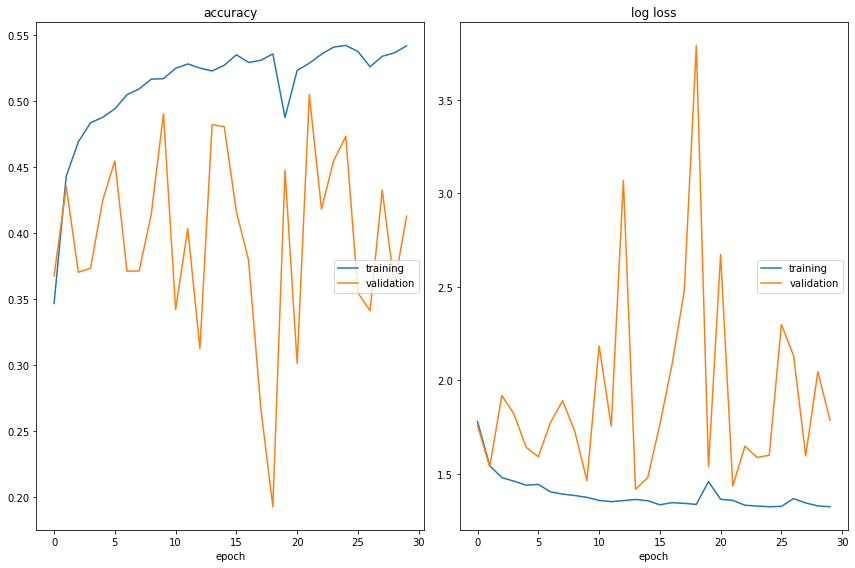

accuracy
	training         	 (min:    0.347, max:    0.542, cur:    0.542)
	validation       	 (min:    0.193, max:    0.505, cur:    0.413)
log loss
	training         	 (min:    1.323, max:    1.779, cur:    1.323)
	validation       	 (min:    1.417, max:    3.792, cur:    1.785)


In [ ]:
lr = 1e-1
momentum = 0.5
example_run, _ , _ = train_model(momentum, lr, visualize=True)

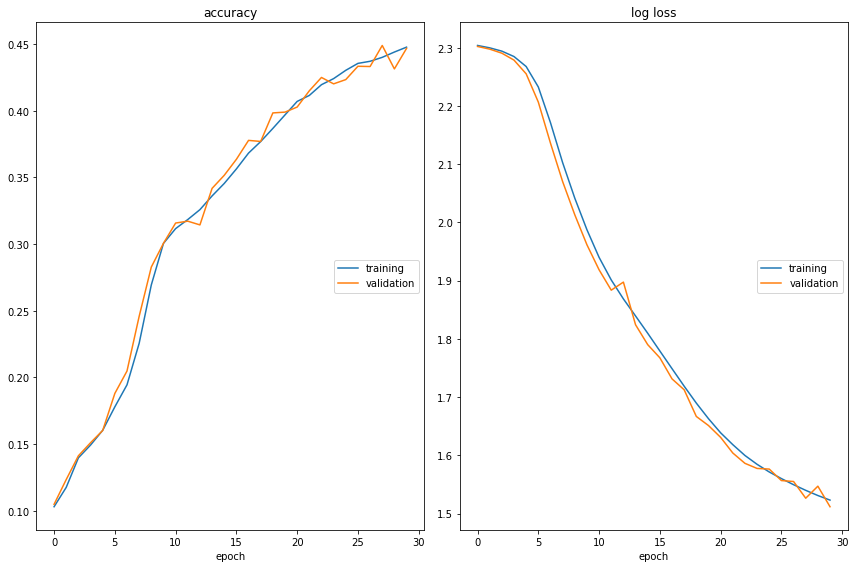

accuracy
	training         	 (min:    0.103, max:    0.448, cur:    0.448)
	validation       	 (min:    0.105, max:    0.449, cur:    0.447)
log loss
	training         	 (min:    1.523, max:    2.304, cur:    1.523)
	validation       	 (min:    1.512, max:    2.302, cur:    1.512)


In [ ]:
lr = 1e-3
momentum = 0.2
example_run, _ , _ = train_model(momentum, lr, visualize=True)

## 6-Train with best hyperparameters [5 points]

Once you have your two best hyperparameters, retrain the model by combining the validation, training, and test sets as you see fit. Report the final accuracy on the test set. Use `livelossplot` to plot the values of the training evolution.

From the tables of losses and accuracies given by grid search in question 5, we could oberserve that the best learning rate is **1e-2** and the best momentum is **0.8**.

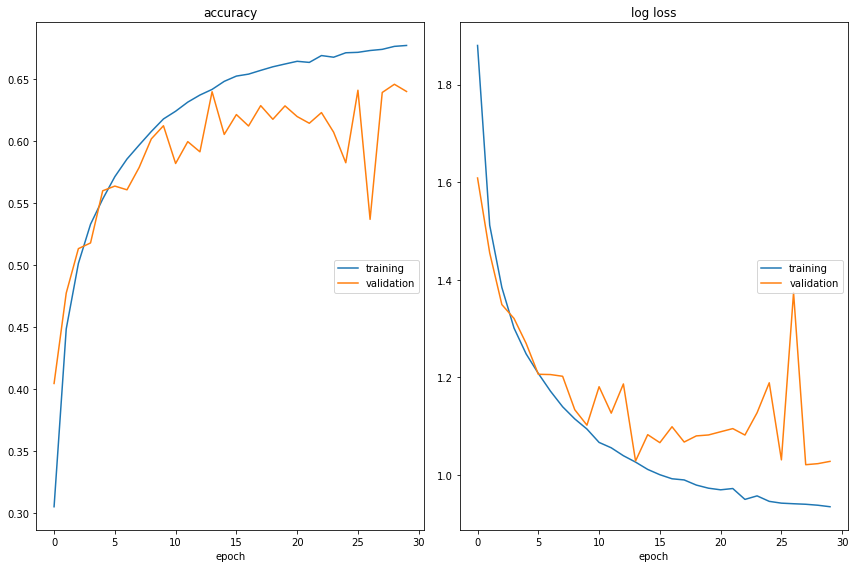

accuracy
	training         	 (min:    0.305, max:    0.677, cur:    0.677)
	validation       	 (min:    0.405, max:    0.646, cur:    0.640)
log loss
	training         	 (min:    0.935, max:    1.880, cur:    0.935)
	validation       	 (min:    1.021, max:    1.609, cur:    1.028)


In [15]:
# define our best learning rate and momentum
best_lr = 1e-2
best_momentum = 0.8
# do livelossplot for the training evolution
best_model, loss , accuracy = train_model(best_momentum, best_lr, visualize=True)

Let's test the accuracy of this "best model" we find over the test dataset:

In [16]:
# define CrossEntropy as the criterion function used
criterion = nn.CrossEntropyLoss()
# load the test data, with test_batch_size set as 1000
test_loader = DataLoader(cifar_test, batch_size= test_batch_size, shuffle=False, num_workers=0)
# print the test_loss and test_accuracy
test_loss, test_accuracy = validate(best_model, criterion, test_loader)    
print("Test Loss: %1.3f" % test_loss.item(), "Test Accuracy: %1.3f" % test_accuracy.item())
print("")

Test Loss: 1.029 Test Accuracy: 0.644



We could see that our validation accuracy is close to the training accuracy, also the test accuracy is even a silghtly larger than the validation accuracy, which verifies that our model is not overfitting. 

## 7-Answer the following questions [1 point each]
Which of these data-augmentation transforms would be reasonable to apply to CIFAR10 and why? 

1. Left-Right Flips
2. Random Rotations by up to 10 Degrees
3. Up-Down Flips
4. Shifting up-down, left-right by 5 pixels
5. Contrast Changes
6. Adding Gaussian Noise
7. Random Rotations by up to 90 Degrees

Justify each one of your answers.

---

Write your answers here:

1. Yes, this method can be applied. As the 10 classes in the CIFAR-10 dataset are all objects in the real world, or say, 3-D object, with Left-Right Flips, the photo should represent the same staff with a different shooting direction. Thus a new data represent a same class can be generated in this way.
2. Yes, this method can be applied. The reason is similar as 1. Rotate the picture in the CIFAR-10 dataset with an random angle will not affect the 3-D project it represents.
3. Yes, this method can be applied. The reason is similar as 1. With Up-Down Flips, though most of the pictures in the CIFAR-10 dataset will represent a strange angle, for example, an upside down cat / dog, but it still not affect the 3-D project it represents.
4. No, this method shouldn't be applied. Suppose if there is a picture, say "a deer" in the CIFAR-10 dataset, and the deer's head happen to be lied on the up-right corner of this photo. If we do a left-right shifting, the deer's head will just disappear! This will lead to the data lose its main feature for classification. You could imagine an photo with half of the animal's body, even a human can not classify it.
5. Yes, this method can be applied. Change the contrast (in a appropriate way) for a picture in CIFAR-10 dataset could make its main feature more distinguishable. For example, sharpen the boundary bewteen the body of a cat and the background. Actually many kinds of techniques, like contrast stretching, histogram equalization, gamma transformation can be applied for data-augmentation.
6. Yes, this method can be applied. Adding Gaussian Noise will make the tensor data smoother (similar to blurring), as long as the noise is not too big, the main feature still remains for some extent, and it could be a very good technique to train a much more robost neural network.
7. Yes, this method can be applied. The reason is similar as 2. Rotate the picture in the CIFAR-10 dataset with an random angle will not affect the 3-D project it represents.



## 8-Plot augmented data [13 points]

Select one of the data-augmentation transforms you decided were reasonable in the previous question. Implement it, and apply it to 9 images of the CIFAR-10 dataset.

Plot the 9 transformed images.

First, we randomly load 9 images from the CIFAR-10 dataset, and plot them:

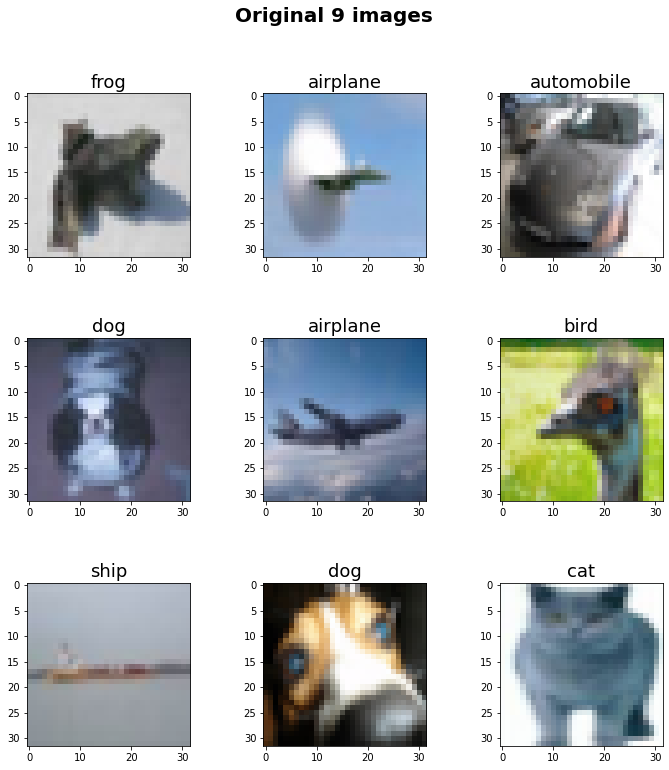

In [19]:
# set a figure with 9 subplots as required.
fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
# adjust the vertical gap for subplots, sparing some place for label names.
pylab.subplots_adjust(hspace=0.5)
# we randomly pick 9 integers from (0, 50000).
picnums = np.random.randint(0,cifar_train.data.shape[0], 9)

# loop over the 9 random integers we have, plot the corresponding picture in the training dataset, as well as their label names.
for ax, picnum in zip(axarr.flatten(), picnums):
  im = ax.imshow(cifar_train.data.permute(0,2,3,1).detach().cpu().numpy()[picnum])
  ax.set_title(r'{0:}'.format(labels[cifar_train.targets.detach().cpu().numpy()[picnum]]), fontsize=18)

# show pictures
suptitle('Original 9 images',fontsize=20, fontweight='bold')
plt.show()

Then we choose the data-augmentation transform **7. Random Rotations by up to 90 Degrees**. <br>
we will use the `transforms.functional.rotate` function to rotate our input image (here the `tensor` format) with a random integer angle between (-90, 90) degree, the results are below:

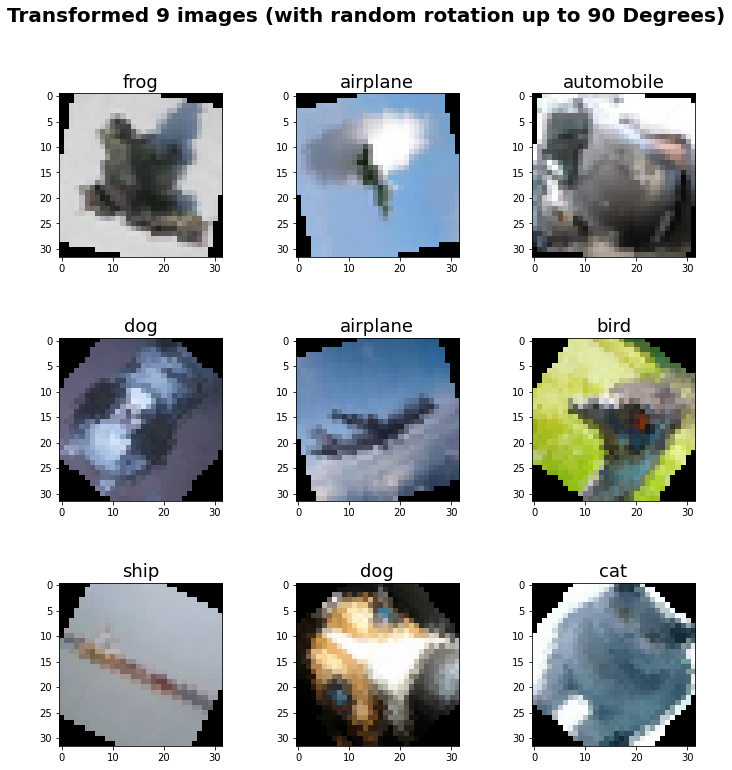

In [20]:
# set a figure with 9 subplots as required.
fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
# adjust the vertical gap for subplots, sparing some place for label names.
pylab.subplots_adjust(hspace=0.5)
# set random degrees within (-90, 90) for the rotation
random_degrees = np.random.randint(-90, 90, 9)

# loop over the 9 random integers we have, plot the corresponding picture in the training dataset, as well as their label names.
for i, picnum in zip(range(9), picnums):
  transfromed_image = transforms.functional.rotate(cifar_train.data[picnum], int(random_degrees[i]))
  ax = axarr.flatten()[i]
  im = ax.imshow(transfromed_image.permute(1,2,0).detach().cpu().numpy())
  ax.set_title(r'{0:}'.format(labels[cifar_train.targets.detach().cpu().numpy()[picnum]]), fontsize=18)

# show transformed images
suptitle('Transformed 9 images (with random rotation up to 90 Degrees)',fontsize=20, fontweight='bold')
plt.show()

## 9-Visualising loss landscapes paper [10 points]

Read the provided paper [Visualising the Loss Landscape of Neural Nets](https://arxiv.org/pdf/1712.09913.pdf).

This paper is contains a lot of advanced concepts. You only need to read and understand it well up to, and including, section 4, (Proposed Visualization: Filter-Wise Normalisation) to answer the questions below. In section 4 you don't need to fully understand the rationale for doing Filter-Wise Normalisation, but you do need to understand what Filter-Wise Normalisation is.

Answer the following questions (in a markdown cell):

1. What are $\delta$, $\eta$, $\alpha$ and $\beta$ in equation (1)? [5 points]
2. What does Filter-Wise Normalisation do? [5 points] Don't need to explain the reasons for doing it, just how it modifies the random directions $\delta$ and $\eta$. 

Explain well and justify your answers. **(Don't answer in 1. that $\delta$ is a random direction just because it says that in 2. Explain what is meant by a random direction well.)**

---

Write you answers here:

1) <br>

$\boldsymbol{\delta}$ and $\boldsymbol{\eta}$ are random vectors of which the dimensions are compatible with the parameter $\boldsymbol{\theta}$  of our model. Moreover, each of them are sampled from Gaussian distributions with Filter-Wise Normalisation (see explaination below in 2.), and thay acts like a basis for our 2-dimensional plots (contour and surface plot). For equation(1):<br>
<br>
$$
f(\alpha, \beta) = L(\boldsymbol{\theta}^\ast + \alpha  \boldsymbol{\delta} + \beta  \boldsymbol{\eta})  \tag{1}
$$

$f$ is the scalar function we are plotting in the 2-dimensional plots, $L$ the loss function and $\boldsymbol{\theta^\ast}$ is the fixed center point for the plot (in the normal case, we just assign it with our model's parameter `model.parameters`).

if we write
$$
\boldsymbol{x} = \boldsymbol{\theta}^\ast + \alpha  \boldsymbol{\delta} + \beta  \boldsymbol{\eta} \tag{2}
$$

we could oberseve that $\boldsymbol{x} \in \boldsymbol{\theta}^\ast + \text{span}
\left(\boldsymbol{\delta}, \boldsymbol{\eta}\right)$, which means $\boldsymbol{\delta}$ and $\boldsymbol{\eta}$ are just the 2 basis vectors which forms a 2-D plane in a higher order dimension space (the variable plane of the 2-D plot), with $\boldsymbol{\theta}^\ast$ to be the origin.

Also by looking at (2), we could see $\alpha$ and $\beta$ are the variables for our 2-variable scalar function $f$, and also the scalar coefficients corresponds to $\boldsymbol{\delta}$ and $\boldsymbol{\eta}$ for the vectorized variable $\boldsymbol{x}$, of $L(\boldsymbol{\theta}^\ast + \alpha  \boldsymbol{\delta} + \beta  \boldsymbol{\eta}) = L(\boldsymbol{x})$.

2) <br>
 Suppose we have a random Gaussian direction vector $\boldsymbol{d}$ with dimensions compatible with $\boldsymbol{\theta}^\ast$, The Filter-Wise Normalisation normalize each filter in $\boldsymbol{d}$ to have the same norm of the corresponding filter in $\boldsymbol{\theta}^\ast$. <br>
So in this question, we alter the two vectors $\boldsymbol{\delta}$ and $\boldsymbol{\eta}$ to: <br><br>
$$
\boxed{
\begin{aligned}
For \; j = 0, 1, 2, 3 \cdots \text{number of filters} - 1 , \,\,\,\,\;&\forall i \in [0,\; \text{length of filter}\; j - 1],\\ \boldsymbol{\delta}_{i,j} &\longleftarrow \frac{\boldsymbol{\delta}_{i,j}}{\|\boldsymbol{\delta}_{i,j}\|} \; \|\boldsymbol{\boldsymbol{\theta}^\ast}_{i,j}\| \\\\
\boldsymbol{\eta}_{i,j} &\longleftarrow \frac{\boldsymbol{\eta}_{i,j}}{\|\boldsymbol{\eta}_{i,j}\|} \; \|\boldsymbol{\boldsymbol{\theta}^\ast}_{i,j}\|
\end{aligned}
}
$$
<br>
where $\|\cdot\|$ denotes the Frobenius norm.

We could take a look of the function `create_random_directions` in the example code given below: <br>
In 
```python 
direction = [torch.randn(w.size()).to(device) for w in weights]
```
, we just separate the parameters by each filter, and create a list of length 10 (LeNet-5 network has 10 filters).

Then we loop over each filter and do the Filter-Wise Normalisation: <br>
$$
\boldsymbol{d}_{i,j} \longleftarrow \frac{\boldsymbol{d}_{i,j}}{\|\boldsymbol{d}_{i,j}\|} \; \|\boldsymbol{\boldsymbol{\theta}^\ast}_{i,j}\|
$$
as implemented with the following code: <br>
```python

for d, w in zip(direction, weights):
        if ignore1D and d.dim() <= 1:
            d.fill_(0)
        d.mul_(w.norm()/(d.norm() + 1e-10)) # add small perturbation to avoid division by zero

```
here the iterating element $w$ is just ${\boldsymbol{\theta}^\ast}_{i,j}$.




## 10-Visualise loss landscape [15 points]

Use the formula described in equation (1) in the paper in combination with the Filter-Wise Normalisation to generate landscape plots. For that use your final trained model (output of question **6**) and 25 values for $\alpha$ and 25 values for $\beta$ to generate a 2D plot with a 625 points. Use the provided snippets of code in the Jupyter Notebook template to assist you in generating the plots and to guide you in the functions you will need to implement (not mandatory, you can implement everything from scratch if you prefer).

Note that in this question you will not be comparing the smoothness of different loss landscapes (as they do in the paper), you will only be plotting the loss function landscape around the loss value corresponding to your trained network.



In [42]:
# The following snippets of code are only to assist you. You can decide to use 
# them or not. They are only intended to provide you with some functionality
#  you may find useful when trying to generate the loss landscape plots.


# function to create random directions:
def create_random_directions(weights, ignore1D, seed):
    torch.manual_seed(seed)
    direction = [torch.randn(w.size()).to(device) for w in weights]

    # apply filter normalisation, where every perturbation d in direction has the same norm as its corresponding w in weights
    for d, w in zip(direction, weights):
        if ignore1D and d.dim() <= 1:
            d.fill_(0)
        d.mul_(w.norm()/(d.norm() + 1e-10)) # add small perturbation to avoid division by zero

    return direction


# function to update weigths
def update_weights(model, origin_weights, x_dir, y_dir, dx, dy):
    updates = [x.to(device)*dx + y.to(device)*dy for (x, y) in zip(x_dir, y_dir)]
    for (p, w, u) in zip(model.parameters(), origin_weights, updates):
        p.data = w + u


# function to plot loss landscape as a surface
def plot_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(8, 8),subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xx, yy, loss_landscape, cmap='viridis', edgecolor='none',
                       linewidth=0, antialiased=True,  rstride=1, cstride=1,)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    ax.set_zlabel(r'Loss')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# function to plot loss landscape as a contour, and mark the minima
def contour_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(7, 7))
    cset = plt.contourf(xx, yy, loss_landscape, levels=100, cmap='hot_r')
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    fig.colorbar(cset, shrink=0.5, aspect=5)
    # mark out the minima
    minima_coordinates, minima_f = np.unravel_index(np.argmin(loss_landscape),loss_landscape.shape), np.min(loss_landscape)
    ax.plot(xx[minima_coordinates], yy[minima_coordinates],'r*')
    # annotation
    off1 = -80
    off2 = 50
    bbox = dict(boxstyle="round", fc='salmon', alpha=0.6)
    arrowprops = dict(arrowstyle="->", connectionstyle="arc3,rad=0.")
    annotation = ax.annotate(('minima achieves at ({0:.4f}, {1:.4f}),\n minimal loss = {2:f}'.format(xx[minima_coordinates], yy[minima_coordinates], minima_f)), 
                                 xy=(xx[minima_coordinates], yy[minima_coordinates]), xytext=(off1, off2), textcoords='offset points',
                              bbox=bbox, arrowprops=arrowprops, size=15)
    annotation.set_visible(True)
    plt.show()


# BONUS: functions to compute the angle between 2 random vectors
# in high-dimensional spaces two random vectors are quite likely to be
# orthogonal (or almost). No points involved here, this is just for fun!
#
def angle(vec1, vec2):
    return torch.acos(torch.dot(vec1, vec2)/(vec1.norm()*vec2.norm())).item()

def rad2deg(angle):
    return angle*180/np.pi

# altered this function to return a copy of torch tensor
def concat_torch_list(torch_list):
    torch_list_copy = []
    for i, t in enumerate(torch_list):
        torch_list_copy.append(t.clone().flatten())
    return torch.cat(torch_list_copy)

Create $\boldsymbol{\delta}$ and $\boldsymbol{\eta}$ (fix $\boldsymbol{\theta}^\ast$ by creating a copy model) :

In [22]:
# first, we make a copy for our best model, in case our 'theta' changes during the "update" process
best_model_copy = copy.deepcopy(best_model)
# create two random directions, sigma and eta, with two different random seeds
sigma = create_random_directions(best_model_copy.parameters(), ignore1D=False, seed=42)
eta = create_random_directions(best_model_copy.parameters(), ignore1D=False, seed=31)
# observe the angle between sigma and eta, using functions concat_torch_list(), angle(), rad2deg() defined above
print(r"The angle between our sigma and eta is (in degrees): {0:.2f}".format(rad2deg(angle(concat_torch_list(sigma), concat_torch_list(eta)))))

The angle between our sigma and eta is (in degrees): 90.09


We could observe that $\boldsymbol{\delta}$ and $\boldsymbol{\eta}$ are almost orthogonal, which indicates they are appropriate to be taken as basis vectors of a 2-D plane.<br>
Next, we choose 25 values of $\alpha$ s and 25 values of $\beta$ s to be on a neighbourhood of 0, and just choose the parameters of our best model obtained in **question.6** (`best_model.parameters()`) to be our center point $\boldsymbol{\theta^\ast}$.

Calculate the loss_function values $L(\boldsymbol{\theta}^\ast + \alpha  \boldsymbol{\delta} + \beta  \boldsymbol{\eta})$ w.r.t the $(\alpha, \beta)$ s, assign those values to `loss_landscape`.<br>
First, we choose both $\alpha$ and  $\beta$ $\in [-0.096, 0.096]$:

In [ ]:
# set alphas and betas
alphas = np.linspace(-0.096, 0.096, 25)
betas = np.linspace(-0.096, 0.096, 25)

# create meshgrid
xx, yy = np.meshgrid(alphas, betas)

# calculate loss functions
loss_landscape = np.zeros((25, 25))
for i in range(25):
  for j in range(25):
    dx = xx[i][j]
    dy = yy[i][j]

    # calculate loss for each grid
    update_weights(best_model_copy, best_model.parameters(), sigma, eta, dx, dy)
    loss_landscape[i, j] = validate(best_model_copy, criterion, train_loaders)[0].item()

### Plot loss landscape as a surface:

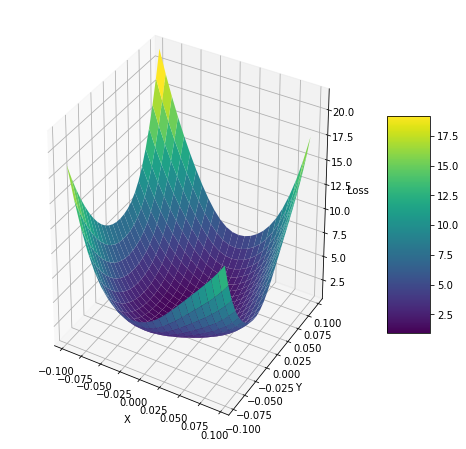

In [24]:
plot_loss_landscape(xx, yy, loss_landscape)

### Plot loss landscape as a contour (colormap changed, mark the minima):

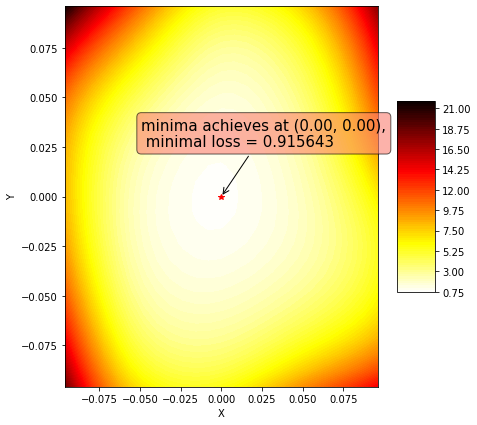

In [25]:
contour_loss_landscape(xx, yy, loss_landscape)

From the plots above, we could observe that our center point $\boldsymbol{\theta^\ast}$ is indeed the global minima within its nergibourhood, also we could observe that the loss_landscape plot is very smooth, as stated in **Section 5** of [Visualising the Loss Landscape of Neural Nets](https://arxiv.org/pdf/1712.09913.pdf), this may because of that the batch size we choose for our best_model in **question.6** is quite small (only 64).

Next, we reduce our $\alpha$ and  $\beta$ s to  $\frac{1}{10}$, that is, $\alpha$ and  $\beta$ $\in [-0.0096, 0.0096]$, which reduce the total region to $\frac{1}{100}$:

In [28]:
# set alphas and betas
alphas = np.linspace(-0.0096, 0.0096, 25)
betas = np.linspace(-0.0096, 0.0096, 25)

# create meshgrid
xx, yy = np.meshgrid(alphas, betas)

# calculate loss functions
loss_landscape = np.zeros((25, 25))
for i in range(25):
  for j in range(25):
    dx = xx[i][j]
    dy = yy[i][j]

    # calculate loss for each grid
    update_weights(best_model_copy, best_model.parameters(), sigma, eta, dx, dy)
    loss_landscape[i, j] = validate(best_model_copy, criterion, train_loaders)[0].item()

### Plot loss landscape as a surface:

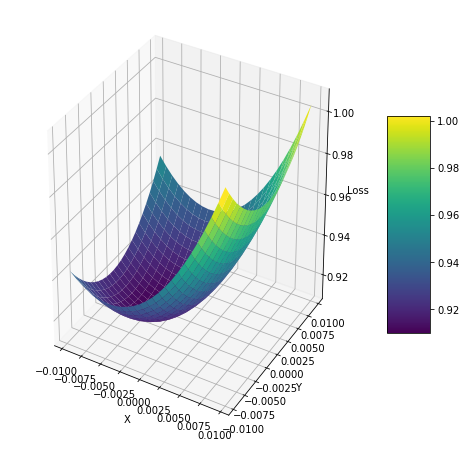

In [29]:
plot_loss_landscape(xx, yy, loss_landscape)

### Plot loss landscape as a contour:

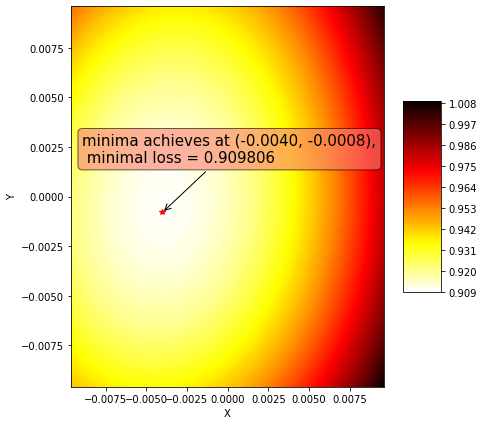

In [43]:
contour_loss_landscape(xx, yy, loss_landscape)

we could observe that the parameters for our 'best model' (`best_model.parameters()`) is no longer the global minima in this "finer" neighborhood anymore, which indicates that we actually did not reach the end of the optimization.<br>
<br>
Also, from the contour plot, we could see that loss surface is sharper on the positive direction $\delta$ than the negative direction of $\delta$.

### 10-(continued)

Discuss your results, and justify the choices you make along the generation process of plotting the loss landscapes (for example the range your choose for your $\alpha$ and $\beta$ values).

---

Write your answers here:<br>
1) We choose `best_model.parameters()` to be our center point $\boldsymbol{\theta^\ast}$, which enables us to better observe whether the parameters we obtained for our best model in **question.6** is really a global minima over its nerbourhood in the loss_landscape.

2) We choose the $\alpha$ and $\beta$ values to be two identical arrays 
`np.linspace(-0.096, 0.096, 25)` (or `np.linspace(-0.0096, 0.0096, 25)`), which devides the interval$[-0.096, 0.096]$ (or $[-0.0096, 0.0096]$) into 24 subintervals with equal length (similar to Newton quadrature nodes). This could give us a square neighborhood of $\boldsymbol{\theta^\ast}$, and a even grid could give us a preciser (and fairer) visualization of how scalar function $f$ varies over direction $\boldsymbol{\delta}$ and $\boldsymbol{\eta}$.